# Coursera Data Science Capstone

### Mark Polinkovsky
### May 9, 2020

<b> Introduction / Business Problem </b>

People moving to a different city often want to settle in a neighborhood that is similar to the one they have been living in.  Because the person is new to the city, they may not be familiar with the various neighborhoods and their individual characters.  How can they choose a neighborhood to make sure it fits their familiar lifestyle?  Given their home neighborhood, its "venues" can be analyzed and matched to similar neighborhoods in the new city.  This would be a valuable service that real estate agents can provide to their customers, to help them narrow down the neighborhood choices to those that would be best.  It will make the customer happy by helping them find the ideal neighborhood for their lifestyle, and will help the real estate agent by improving the quality of service they offer, and by helping them narrow their focus to the desired neighborhoods.

<b> Data </b>

For the customer's current location, the current address will be needed.  The address will be used to find its latitude and longitude.  The data needed in the new cities is the list of neighborhoods and their postal codes, to find their latitude and longitude.  For both the current location and the new cities, the Foursquare data on venues near the neighborhood centers will be needed.  For this project, we will focus on Toronto and New York City as the new cities, since we have the neighborhood information already.

The new cities' neighborhoods will be clustered using k-means clustering, based on the types of the top 30 venues in that neighborhood.  The original neighborhood's venue types for the top 30 venues will also be calculated.  The K-means model will then be used to predict which cluster of neighborhoods in each of the new cities the original address matches best with.  This way, the neighborhoods in the new city that belong to that cluster will be returned as matches by similarity to the customer's old neighborhood.

In [1]:
#import all necessary libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
from bs4 import BeautifulSoup # HTML Parsing library

import geocoder

import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


Set up Foursquare details for queries

In [2]:
CLIENT_ID = '3NHOBPCDSRG1R0LMHUGB0ROC2Q1AET32BM5YLMEFFEVTEP4G' # your Foursquare ID
CLIENT_SECRET = '3BF4AGXETKHU3PDUGNW4SPMSBZ5FMWGRCODJW3130MQCWXM5' # your Foursquare Secret
VERSION = '20200505'#'20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3NHOBPCDSRG1R0LMHUGB0ROC2Q1AET32BM5YLMEFFEVTEP4G
CLIENT_SECRET:3BF4AGXETKHU3PDUGNW4SPMSBZ5FMWGRCODJW3130MQCWXM5


Get data on Toronto neighborhoods

In [ ]:
#Get list of Toronto neighborhoods from Wikipedia page
page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(page.text,'html.parser')

In [ ]:
#Read scraped data into data frame
dftor=pd.read_html(str(soup.table))[0]

#The column headings are brought in as row 0, so make column titles, drop the 0th record, and reset the index
dftor.columns=['Postal code','Borough','Neighborhood']
dftor.drop(index=0,inplace=True)
#Clean up the data
#Remove 'Not assigned' Boroughs, and switch 'Not assigned' neighborhoods to their borough names (there are none of those)
dftor=dftor[dftor['Borough']!='Not assigned']
dftor.loc[dftor['Neighborhood']=='Not assigned','Neighborhood']=dftor.loc[dftor['Neighborhood']=='Not assigned','Borough']

#Replace multiple neighborhood separator from / to ,
dftor['Neighborhood']=dftor['Neighborhood'].str.replace(pat=r' /',repl=',',regex=False)

#Reset the index
dftor.reset_index(drop=True,inplace=True)

dftor.head()

Find Latitude and Longitude of Toronto neighborhoods

In [ ]:
#Initialize variables
latdict={'Latitude':[0]*len(dftor),'Longitude':[0]*len(dftor)}
latlng = pd.DataFrame(data=latdict)
#Default Toronto latitude longitude
torontolatlng = (43.6529,-79.3849)

#Step through each postal code
for n in range(0,len(dftor)):#len(dftor)):
    
    #initialize variables for loop
    lat_lng_coords = None
    postal_code = dftor.loc[n,'Postal code']
    borough = dftor.loc[n,'Borough']    
    q=0;
    
    # loop until you get the coordinates or do 10 tries
    while((lat_lng_coords is None) and (q<10)):
#        print('{}, {}, Toronto, Ontario, Canada'.format(postal_code, borough))
        
        #Use Arcgis to get location data
        g = geocoder.arcgis('{}, Toronto, Ontario, Canada'.format(postal_code))    
        
        if g.json != None:
            lat_lng_coords = (g.json['lat'],g.json['lng'])
            
        q+=1
    
    #If no latitude, longitude found, set to center of Toronto as default
    if (lat_lng_coords is None):
        lat_lng_coords = torontolatlng
    
#    print(n, q)
#    print(lat_lng_coords)
        
    latlng.loc[n,'Latitude'] = lat_lng_coords[0]
    latlng.loc[n,'Longitude'] = lat_lng_coords[1]

dftor=pd.concat([dftor,latlng],axis=1)
dftor.head()

In [ ]:
dftor.to_csv('torontohoods_lat_long.csv', sep=',')

Define function to get venues for each neighborhood

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=750, LIMIT=30):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&sortByPopularity=1'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
toronto_venues = getNearbyVenues(names=dftor['Neighborhood'],latitudes=dftor['Latitude'], 
                                 longitudes=dftor['Longitude'])

In [ ]:
toronto_venues.shape

In [ ]:
toronto_venues.to_csv('torontovenues.csv',sep=',')

Can read in previously saved data to avoid re-running service queries

In [3]:
dftor = pd.read_csv('torontohoods_lat_long.csv')
toronto_venues = pd.read_csv('torontovenues.csv')

#### Switching to NYC and doing a similar analysis to get venue data for each neighborhood
Get list of NYC neighborhoods from CUNY Baruch data set

In [259]:
#Better to use NYC Open Data set below, but if this data is to be used, uncomment the lines below
#!pip install wget
#import wget
#ny_hoods=wget.download('http://faculty.baruch.cuny.edu/geoportal/resources/nyc_geog/nyc_puma_neighborhood.xls')
#ny_boro=pd.read_excel(ny_hoods)

Getting NYC Neighborhood names and locations from NYC Open Data (https://data.cityofnewyork.us/City-Government/Neighborhood-Names-GIS/99bc-9p23)

In [ ]:
ny_boro=pd.read_csv('NHoodNameCentroids.csv')

In [ ]:
ny_boro.head()

Find Latitude and Longitude of NYC neighborhoods

In [ ]:
ny_boro=ny_boro[['Name','Borough','the_geom']]
len(ny_boro)

In [ ]:
#Extract Latitude and Longitude from "the_geom" field
ny_boro['the_geom']=ny_boro['the_geom'].str.replace('POINT (','',regex=False)
ny_boro['the_geom']=ny_boro['the_geom'].str.replace(')','',regex=False)
latsplit=ny_boro['the_geom'].str.find(' ')

for n in range(len(ny_boro)):
    if latsplit[n]>=0:
        ny_boro.loc[n,'Latitude']=ny_boro.loc[n,'the_geom'][latsplit[n]+1:]
        ny_boro.loc[n,'Longitude']=ny_boro.loc[n,'the_geom'][0:latsplit[n]]
    else:
        ny_boro.loc[n,'Latitude']=nyclatlong[0]
        ny_boro.loc[n,'Longitude']=nyclatlong[1]
        
print(ny_boro.head())

In [ ]:
ny_boro['Neighborhood']=ny_boro['Name']
dfnyc=ny_boro[['Neighborhood','Latitude','Longitude']]
dfnyc=dfnyc.astype({'Latitude':'float64','Longitude':'float64'},copy=False)
print(dfnyc.dtypes)
dfnyc.head()

In [ ]:
#Output to file so it can be recalled in later sessions
dfnyc.to_csv('nychoods_lat_long.csv',sep=',')

Get venues in each neighborhood

In [ ]:
nyc_venues = getNearbyVenues(names=dfnyc['Neighborhood'],latitudes=dfnyc['Latitude'], 
                                 longitudes=dfnyc['Longitude'])

In [ ]:
print(nyc_venues.shape)
nyc_venues.to_csv('nycvenues.csv',sep=',')

Can read in previously saved data to avoid re-running service queries

In [4]:
dfnyc=pd.read_csv('nychoods_lat_long.csv')
nyc_venues=pd.read_csv('nycvenues.csv')

### Cluster neighborhoods in both cities using their venue types
#### Starting with Toronto
Perform one-hot encoding

In [5]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
cols=list(toronto_onehot)
cols.insert(0, cols.pop(cols.index('Neighborhood')))
toronto_onehot = toronto_onehot.loc[:, cols]
toronto_onehot

toronto_onehot.head()

,Neighborhood,Airport,American Restaurant,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Bar,Beer Store,Big Box Store,Bistro,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Quad,College Stadium,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Curling Ice,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distribution Center,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nightclub,Office,Optical Shop,Other Great Outdoors,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pilates Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shipping Store,Shopping Mall,Shopping Plaza,Skating Rink,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tibetan Restaurant,Trail,Train Station,Tram Station,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Group by neighborhood and frequency of venue category

In [151]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.shape

(97, 252)

Find optimal K in K-means clustering using the Elbow method

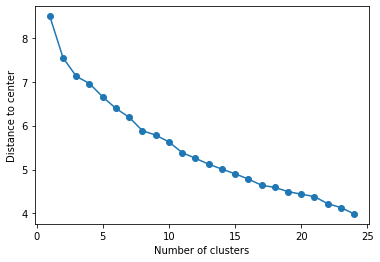

In [152]:
distmeas = []
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
maxk=25

for i in range(1, maxk):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(toronto_grouped_clustering)
    distmeas.append(km.inertia_)

# plot
plt.plot(range(1, maxk), distmeas, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distance to center')
plt.show()

A reasonable choice of K looks like 8 or 11 for Toronto.

In [153]:
k_tor = 8
# run k-means clustering
kmeanstor = KMeans(n_clusters=k_tor, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeanstor.labels_[0:10]

array([6, 6, 6, 2, 6, 3, 1, 6, 3, 6])

In [154]:
#dftor['Cluster']=kmeans.labels_
toronto_grouped.head()
torclust=pd.Series(kmeanstor.labels_,name='Cluster')
dftormer=pd.concat([toronto_grouped['Neighborhood'],torclust],axis=1)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dftormer = dftormer.join(dftor.set_index('Neighborhood'), on='Neighborhood')

dftormer.head()

,Neighborhood,Cluster,Unnamed: 0,Postal code,Borough,Latitude,Longitude
0,Agincourt,6,78,M1S,Scarborough,43.793930,-79.265694
1,"Alderwood, Long Branch",6,93,M8W,Etobicoke,43.600895,-79.540387
2,"Bathurst Manor, Wilson Heights, Downsview North",6,28,M3H,North York,43.757394,-79.442394
3,Bayview Village,2,39,M2K,North York,43.780607,-79.376921
4,"Bedford Park, Lawrence Manor East",6,55,M5M,North York,43.735447,-79.417944


In [155]:
dftormer.to_csv('TorontoClusters.csv',sep=',')

In [156]:
torontolatlng = (43.6529,-79.3849)
nyclatlng = (40.730610,-73.935242)

In [157]:
# create map
map_clusters = folium.Map(location=[torontolatlng[0], torontolatlng[1]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_tor)
ys = [i + x + (i*x)**2 for i in range(k_tor)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dftormer['Latitude'], dftormer['Longitude'], dftormer['Neighborhood'], dftormer['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Now find clusters for NYC

In [13]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
cols=list(nyc_onehot)
cols.insert(0, cols.pop(cols.index('Neighborhood')))
nyc_onehot = nyc_onehot.loc[:, cols]
nyc_onehot

nyc_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Gym,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Mall,Outlet Store,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recreation Cente

Group by neighborhood and frequency of venue category

In [14]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.shape

(295, 378)

Find optimal K in K-means clustering using the Elbow method

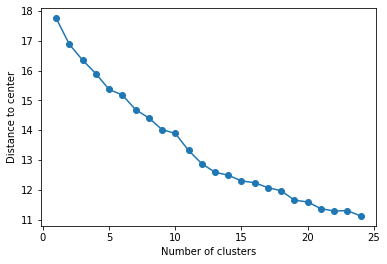

In [40]:
distmeas = []
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)
maxk=25

for i in range(1, maxk):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(nyc_grouped_clustering)
    distmeas.append(km.inertia_)

# plot
plt.plot(range(1, maxk), distmeas, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distance to center')
plt.show()

A reasonable choice of K looks like 9 or 12 for NYC

In [16]:
k_nyc = 9
# run k-means clustering
kmeansnyc = KMeans(n_clusters=k_nyc, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeansnyc.labels_[0:10]

array([1, 1, 2, 1, 2, 7, 1, 1, 1, 4])

In [17]:
#dfnyc['Cluster']=kmeans.labels_
nyc_grouped.head()
nycclust=pd.Series(kmeansnyc.labels_,name='Cluster')
dfnycmer=pd.concat([nyc_grouped['Neighborhood'],nycclust],axis=1)

# merge nyc_grouped with nyc_data to add latitude/longitude for each neighborhood
dfnycmer = dfnycmer.join(dfnyc.set_index('Neighborhood'), on='Neighborhood')

dfnycmer.head()

,Neighborhood,Cluster,Unnamed: 0,Latitude,Longitude
0,Annadale,1,217,40.538114,-74.178549
1,Arden Heights,1,243,40.549286,-74.185887
2,Arlington,2,229,40.635325,-74.165104
3,Arrochar,1,230,40.596313,-74.067124
4,Arverne,2,179,40.589144,-73.791992


In [18]:
dfnycmer.to_csv('nycClusters.csv',sep=',')

In [19]:
# create map
map_clusters = folium.Map(location=[nyclatlng[0], nyclatlng[1]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_nyc)
ys = [i + x + (i*x)**2 for i in range(k_nyc)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfnycmer['Latitude'], dfnycmer['Longitude'], dfnycmer['Neighborhood'], dfnycmer['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Read in previously saved data from files

In [ ]:
#dftormer=pd.read_csv('TorontoClusters.csv',sep=',')
#dfnycmer=pd.read_csv('nycClusters.csv',sep=',')

### Finding similarities between customer's address and NYC and Toronto Neighborhoods

Define function to get venues around an address

In [122]:
def getAddressVenues(names, lat, lng, radius=750, LIMIT=30):
    
    venues_list=[]
   
    print(names)
            
        # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&sortByPopularity=1'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)
            
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
        
    # return only relevant information for each nearby venue
    venues_list.append([(
        names, 
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'Address', 
        'Address Latitude', 
        'Address Longitude',
        'Venue', 
        'Venue Latitude', 
        'Venue Longitude', 
        'Venue Category']
    
    return(nearby_venues)

Define function to get the latitude and longitude of an address.

In [123]:
def getaddressdata(address):

    addressinfo=[address]
    
    #initialize variables for loop
    lat_lng_coords = None 
    q=0;
    
    # loop until you get the coordinates or do 10 tries
    while((lat_lng_coords is None) and (q<10)):
        
        #Use Arcgis to get location data
        g = geocoder.arcgis(address)    
        
        if g.json != None:
            lat_lng_coords = [g.json['lat'],g.json['lng']]
            
        q+=1
    
    #If no latitude, longitude found, set to center of Toronto as default
    if (lat_lng_coords is None):
        print('Error getting latitude and longitude')
        return([address,0,0])
    
#    print(n, q)
#    print(lat_lng_coords)

    addressinfo=addressinfo+lat_lng_coords
    print(addressinfo)
    return(addressinfo)

Input the address for which to run analysis

In [260]:
inputaddress="655 Mattaaq, Iqaluit, NU X0A 0H0, Canada"

Get address latitude and longitude, find the nearest venues, and perform one-hot encoding

In [261]:
#Find latitude and longitude of an address
addressinfo=getaddressdata(inputaddress)

#Find venues around the address
address_venues = getAddressVenues(names=addressinfo[0],lat=addressinfo[1], 
                                 lng=addressinfo[2])
# one hot encoding
address_onehot = pd.get_dummies(address_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
address_onehot['Address'] = address_venues['Address'] 

# move neighborhood column to the first column
cols=list(address_onehot)
cols.insert(0, cols.pop(cols.index('Address')))
address_onehot = address_onehot.loc[:, cols]
#address_onehot

address_onehot.head()

address_grouped = address_onehot.groupby('Address').mean().reset_index()

address_grouped_clustering = address_grouped.drop('Address', 1)

#Make copies of dataframe, one for each of NYC and Toronto 
address_groupednyc = address_grouped_clustering.copy()
address_groupedtor = address_grouped_clustering.copy()

['655 Mattaaq, Iqaluit, NU X0A 0H0, Canada', 63.74738044107346, -68.51721991345205]
655 Mattaaq, Iqaluit, NU X0A 0H0, Canada


Predict into which cluster in NYC the address fits

In [262]:
#Make data frame for venues around address have the same columns as the NYC data
for posit,n in enumerate(nyc_grouped_clustering.columns.values):
    if ((n in address_groupednyc.columns.values)==False):
        address_groupednyc.insert(posit,n,0)

for posit,n in enumerate(address_groupednyc.columns.values):
    if ((n in nyc_grouped_clustering.columns.values)==False):
        address_groupednyc.drop(columns=n,inplace=True)
        
#Run K-Means prediction to assign address to one of NYC's clusters
addressnycclust = int(kmeansnyc.predict(address_groupednyc))

print('The best-matching NYC cluster is #', addressnycclust)  #Show the cluster number

#Output neighborhoods in cluster
print('Compatible neighborhoods in NYC')
print(dfnycmer[dfnycmer['Cluster']==addressnycclust]['Neighborhood'].to_string(index=False))


# create map
map_clusters = folium.Map(location=[nyclatlng[0], nyclatlng[1]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_nyc)
ys = [i + x + (i*x)**2 for i in range(k_nyc)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
dfnycmatch = dfnycmer[dfnycmer['Cluster']==addressnycclust]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(dfnycmatch['Latitude'], dfnycmatch['Longitude'], dfnycmatch['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The best-matching NYC cluster is # 1
Compatible neighborhoods in NYC
Annadale
       Arden Heights
            Arrochar
     Astoria Heights
          Auburndale
          Bath Beach
         Bay Terrace
         Bay Terrace
             Bayside
          Beechhurst
            Bellaire
           Bellerose
             Belmont
         Bensonhurst
          Blissville
        Borough Park
       Broad Channel
          Bulls Head
        Butler Manor
         Castle Hill
   Castleton Corners
         City Island
        Country Club
        Dongan Hills
          Douglaston
       Dyker Heights
       East Elmhurst
   East Williamsburg
      Edgewater Park
            Elm Park
         Eltingville
Forest Hills Gardens
       Fort Hamilton
          Georgetown
     Gerritsen Beach
           Glen Oaks
            Glendale
             Gowanus
          Grant City
            Grasmere
           Gravesend
         Great Kills
          Greenpoint
          Greenridge
           Hillcres

Predict into which cluster in Toronto the address fits

In [263]:
#Make data frame for venues around address have the same columns as the Toronto data
for posit,n in enumerate(toronto_grouped_clustering.columns.values):
    if ((n in address_groupedtor.columns.values)==False):
        address_groupedtor.insert(posit,n,0)

for posit,n in enumerate(address_groupedtor.columns.values):
    if ((n in toronto_grouped_clustering.columns.values)==False):
        address_groupedtor.drop(columns=n,inplace=True)
        
#Run K-Means prediction to assign address to one of Toronto's clusters
addresstorclust = int(kmeanstor.predict(address_groupedtor))

print('The best-matching Toronto cluster is #',addresstorclust)  #Show the cluster number

#Output neighborhoods in cluster
print('Compatible neighborhoods in Toronto')
print(dftormer[dftormer['Cluster']==addresstorclust]['Neighborhood'].to_string(index=False))

# create map
map_clusters = folium.Map(location=[torontolatlng[0], torontolatlng[1]], zoom_start=12)

# set color scheme for the clusters
x = np.arange(k_tor)
ys = [i + x + (i*x)**2 for i in range(k_tor)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
dftormatch = dftormer[dftormer['Cluster']==addresstorclust]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(dftormatch['Latitude'], dftormatch['Longitude'], dftormatch['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The best-matching Toronto cluster is # 3
Compatible neighborhoods in Toronto
Berczy Park
   Business reply mail Processing Centre
   Canada Post Gateway Processing Centre
                      Central Bay Street
          Commerce Court, Victoria Hotel
  First Canadian Place, Underground city
                Garden District, Ryerson
                               Northwest
                Richmond, Adelaide, King
                          St. James Town
                          Stn A PO Boxes
Toronto Dominion Centre, Design Exchange
